## Weight quantization using IBM aihwkit - PyTorch
---

In the following notebook, we will demonstrate how to quantize the weights of a given neural network using the IBM aihwkit library. We will use a model inspired by the ResNet9 architecture and the CIFAR-10 dataset as well as a LeNet inspired one, trained ideally on the MNIST datataset. 
For simplicity, to implement the analog version of the model to be used by the simulator, we will use the auxiliary functions defined in the examples [18_cifar10_on_resnet.ipynb](../examples/18_cifar10_on_resnet.py), [30_external_hardware_aware_model.ipynb](../examples/30_external_hardware_aware_model.py) and the tutorial [hw_aware_training.ipynb](../notebooks/tutorial/hw_aware_training.ipynb)  form which this notebook takes ample inspiration. We will also show how to quantize the weights of a model converted from digital to analog using the [built-in functions](../src/aihwkit/nn/conversion.py) provided by the aihwkit library.


We consider a simple analog device composed of ***single device crossbars tiles*** and a ***weight quantization at int3***. For simplicity, consider the simulation to be carried out on the CPU

In [2]:
# !wget https://aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud/aihwkit-0.9.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
# !pip install aihwkit-0.9.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
# !pip install torchmetrics

In [1]:
%matplotlib inline
import os
import torch
from torch import nn, Tensor, device, no_grad, manual_seed
from torch import nn
from torchvision.datasets.utils import download_url
import torch.nn.functional as F
from torchmetrics.functional import accuracy
import torchvision
from torchvision import datasets, transforms
from torch.nn.functional import mse_loss



# print the position of python
import sys
# get the path of the current file
file = os.path.abspath('')
path = os.path.join(file, '../src')
sys.path.append(path)
print(path)
# Print the list of modules imported

from aihwkit.simulator.configs import ConstantStepDevice, SingleRPUConfig, FloatingPointDevice, FloatingPointRPUConfig
from aihwkit.optim import AnalogSGD
from aihwkit.inference.noise.base import BaseNoiseModel
from aihwkit.inference.noise.pcm import PCMLikeNoiseModel
from aihwkit.inference.compensation.drift import GlobalDriftCompensation
from aihwkit.inference.compensation.base import BaseDriftCompensation
from aihwkit.simulator.configs import InferenceRPUConfig
from aihwkit.simulator.presets.utils import PresetIOParameters
from aihwkit.simulator.parameters import (
    MappingParameter,
    IOParameters,
    PrePostProcessingParameter,
    InputRangeParameter,
    WeightClipParameter,
    WeightRemapParameter,
    WeightModifierParameter,
    WeightQuantizerParameter,
)
from aihwkit.simulator.parameters.enums import (
    WeightClipType,
    BoundManagementType,
    NoiseManagementType,
    WeightNoiseType,
    WeightRemapType,
    WeightModifierType,
)
from aihwkit.nn import AnalogLinearMapped, AnalogConv2d, AnalogSequential, AnalogLinear
# from aihwkit.utils.visualization import plot_device_compact
# from aihwkit.utils.analog_info import analog_summary
# from aihwkit.utils.fitting import fit_measurements
from aihwkit.nn.conversion import convert_to_analog
from aihwkit.utils.analog_info import analog_summary
from aihwkit.inference.calibration import (
    calibrate_input_ranges,
    InputRangeCalibrationType,
)
#from aihwkit.simulator.rpu_base import cuda

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dataclasses import dataclass, field
from typing import Optional

import src.plotting as pl

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



/Users/edoardocabiati/Desktop/Cose_brutte_PoliMI/_tesi/aihwkit/sandbox/../src


### Ex.1    AnalogLiner Layer
---

As a simple example, we will consider a single layer composed of a Linear layer and a ReLU activation function. We will train the model using trial, single-samplen dataset and then experiment with the quantization of the weights.
For both the quantized and unquantized models, we will evaluate the accuracy of the model on the same training dataset.

In [4]:

''' Taken form example '01_simple_layer.py' '''
def test():
    RANGE = (-1.2, 1.2)
    # Prepare the datasets (input and expected output).
    x = Tensor([[0.1, 0.2, 0.4, 0.3], [0.2, 0.1, 0.1, 0.3]])
    y = Tensor([[10.4, 30.5], [6.7, 40.3]])

    # Define a single-layer network, using a constant step device type.
    rpu_config = SingleRPUConfig(device=ConstantStepDevice())

    rpu_config.clip = WeightClipParameter(
        type=WeightClipType.FIXED_VALUE,
        fixed_value=0.5,
    )

    rpu_config.quantization = WeightQuantizerParameter(
        resolution = 0.,
        levels = 3,
        eps = 0.5
    )
    model = AnalogLinear(4, 2, bias=True, rpu_config=rpu_config)

    analog_tile = next(model.analog_tiles())
    print("Info about the tile at initialization", analog_tile.get_weights())
    # Plot the initial weights
    #pl.plot_tensor_values(analog_tile.get_weights()[0], 21,RANGE, "Distribution of quantized weights (initial)", "plots/hist1.png")
   

    # Move the model and tensors to cuda if it is available.
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()
        model = model.cuda()

    # Define an analog-aware optimizer, preparing it for using the layers.
    opt = AnalogSGD(model.parameters(), lr=0.1)
    opt.regroup_param_groups(model)

    

    # Train the model.
    for epoch in range(100):
        # Delete old gradient
        opt.zero_grad()
        # Add the training Tensor to the model (input).
        pred = model(x)
        # Add the expected output Tensor.
        loss = mse_loss(pred, y)
        # Run training (backward propagation).
        loss.backward()

        opt.step()

        #print("Loss error: {:.16f}".format(loss))


    # Test the model
    print("\n\nEvaluation of the UNquantized model:")
    model.eval()
    with no_grad():
        pred = model(x)
        print("Predicted: ", pred)
        print("Expected: ", y)
        analog_tile = next(model.analog_tiles())
        print("Info about the tile", analog_tile.get_weights())
    # Plot the initial weights
    #pl.plot_tensor_values(analog_tile.get_weights()[0], 21,RANGE,"Distribution of weights (after training)", "plots/hist2.png")

    rpu_config.quantization = WeightQuantizerParameter(
        resolution = 0.3,
        eps= 0.5,
        levels = 3
    )


    model_new = convert_to_analog(model, rpu_config, )

    # Test the new model
    print("\n\nEvaluation of the quantized model:")
    model_new.eval()
    with no_grad():
        pred = model_new(x)
        print("Predicted: ", pred)
        print("Expected: ", y)
        analog_tile = next(model_new.analog_tiles())
        print("Info about the tile", analog_tile.get_weights())
    # Plot the initial weights
    #pl.plot_tensor_values(analog_tile.get_weights()[0], 21,RANGE,"Distribution of quantized weights (after transfer)", "plots/hist3.png")


In [5]:
test()


Info about the tile at initialization (tensor([[-0.3237,  0.3237,  0.3237, -0.3237],
        [-0.0000,  0.3237,  0.3237,  0.0000]]), tensor([0.3219, 0.4565]))


Evaluation of the UNquantized model:
Predicted:  tensor([[ 8.6535, 35.3106],
        [ 8.4135, 35.4894]])
Expected:  tensor([[10.4000, 30.5000],
        [ 6.7000, 40.3000]])
Info about the tile (tensor([[-0.6438,  0.3285,  0.4762,  0.1507],
        [ 0.6466,  0.1688, -0.5269,  0.6120]]), tensor([ 8.4276, 35.1788]))




Evaluation of the quantized model:
Predicted:  tensor([[ 8.6723, 35.2165],
        [ 8.4418, 35.3906]])
Expected:  tensor([[10.4000, 30.5000],
        [ 6.7000, 40.3000]])
Info about the tile (tensor([[-0.5269,  0.5269,  0.5269,  0.0000],
        [ 0.5269,  0.0000, -0.5269,  0.5269]]), tensor([ 8.4276, 35.1788]))


### Ex.2    LeNet
--- 

A version of LeNet5 has been pretrained on the MNIST dataset. We will convert the model to analog and quantize the weights using the newly implemented quantization functions.

In the following section, some auxiliary functions are defined to download the model and the dataset.

In [6]:
from src.noise import NullNoiseModel

N_CLASSES = 10

USE_ANALOG_TRAINING = True
if USE_ANALOG_TRAINING:
    RPU_CONFIG  = InferenceRPUConfig(forward=IOParameters(is_perfect=True),
                                    noise_model=NullNoiseModel(),
                                    clip= WeightClipParameter(type=WeightClipType.NONE,),
                                    remap= WeightRemapParameter(type=WeightRemapType.NONE,),
                                    modifier= WeightModifierParameter(type=WeightModifierType.NONE,), 
                                    drift_compensation=None,
                                    )
else:
    RPU_CONFIG = FloatingPointRPUConfig(device=FloatingPointDevice())

# Rebuild the LeNet5 model
def inference_lenet5(RPU_CONFIG):
    """Return a LeNet5 inspired analog model."""
    channel = [16, 32, 512, 128]
    model = AnalogSequential(
        AnalogConv2d(
            in_channels=1, out_channels=channel[0], kernel_size=5, stride=1, rpu_config=RPU_CONFIG
        ),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        AnalogConv2d(
            in_channels=channel[0],
            out_channels=channel[1],
            kernel_size=5,
            stride=1,
            rpu_config=RPU_CONFIG,
        ),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        nn.Tanh(),
        nn.Flatten(),
        AnalogLinear(in_features=channel[2], out_features=channel[3], rpu_config=RPU_CONFIG),
        nn.Tanh(),
        AnalogLinear(in_features=channel[3], out_features=N_CLASSES, rpu_config=RPU_CONFIG),
        nn.LogSoftmax(dim=1),
    )

    return model


def get_test_loader_2():
    # Load test data form MNIST dataset

    transform = torchvision.transforms.Compose([transforms.ToTensor()])
    test_set = datasets.MNIST(
        root="data/mnist", train=False, download=True, transform=transform
    )
    test_data = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)
    return test_data


import requests
from urllib.parse import unquote

def download_url(url, dest_folder, filename=None):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)  # create folder if it does not exist

    if filename is None:
        filename = url.split("/")[-1]  # assume that the last segment after / is file name
        filename = unquote(filename)  # unquote 'meaning' convert %20 to space etc.

    file_path = os.path.join(dest_folder, filename)

    r = requests.get(url, stream=True)
    if r.ok:
        print("saving to", os.path.abspath(file_path))
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 8):
                if chunk:
                    f.write(chunk)
                    f.flush()
                    os.fsync(f.fileno())
    else:  # HTTP status code 4XX/5XX
        print("Download failed: status code {}\n{}".format(r.status_code, r.text))

In [7]:
import gdown

if not os.path.exists('lenet'):
    os.makedirs('lenet')
if not os.path.exists('lenet/plots'):
    os.makedirs('lenet/plots')
url = 'https://drive.google.com/uc?id=1-dJx-mGqr5iKYpHVFaRT1AfKUZKgGMQL'
output = 'lenet/lenet5.th'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-dJx-mGqr5iKYpHVFaRT1AfKUZKgGMQL
To: /Users/edoardocabiati/Desktop/Cose_brutte_PoliMI/_tesi/aihwkit/sandbox/lenet/lenet5.th
100%|██████████| 664k/664k [00:02<00:00, 263kB/s]


'lenet/lenet5.th'

#### Model loading in two versions: quantized and unquantized.

A plot of the weights distribution is shown for both versions in the corresponding hist_lenet .gif files.

In [8]:

model = inference_lenet5(RPU_CONFIG).to(device)

state_dict = torch.load("lenet/lenet5.th", device)
model.load_state_dict(state_dict, strict=True, load_rpu_config=False)
model.eval()

# # Print the content of the first tile
# analog_tile = next(model.analog_tiles())
# print("Info about the tile at initialization\n", analog_tile.get_weights())

# Plot the histogram of the weights
pl.generate_moving_hist(model,title="Distribution of Weight\n Values over the tiles - LENET", file_name="lenet/plots/hist_lenet_UNQUANTIZED.gif", range = (-.7,.7), top=None, split_by_rows=False)


# Load the weights of a new model with quantization
RPU_CONFIG.quantization = WeightQuantizerParameter(
    resolution=0.,
    levels = 9,
    eps = 0.08
)
model_9 = convert_to_analog(model, RPU_CONFIG)
tile_weights = next(model_9.analog_tiles()).get_weights()
print(tile_weights[0])
model_9.eval()

# # Print the content of the first tile
# analog_tile = next(model_new.analog_tiles())
# print("Info about the tile at initialization USING QUANTIZATION\n", analog_tile.get_weights())

# Plot the histogram of the weights
pl.generate_moving_hist(model_9,title="Distribution of Quantized Weight\n Values over the tiles - LENET9", file_name="lenet/plots/hist_lenet_QUANTIZED_9.gif", range = (-.7,.7), top = None, split_by_rows=False)

# Load the weights of a new model with quantization
RPU_CONFIG.quantization = WeightQuantizerParameter(
    resolution=0.,
    levels = 17,
    eps = 0.08
)
model_17 = convert_to_analog(model, RPU_CONFIG)
model_17.eval()

# # Print the content of the first tile
# analog_tile = next(model_new.analog_tiles())
# print("Info about the tile at initialization USING QUANTIZATION\n", analog_tile.get_weights())

# Plot the histogram of the weights
pl.generate_moving_hist(model_17,title="Distribution of Quantized Weight\n Values over the tiles - LENET17", file_name="lenet/plots/hist_lenet_QUANTIZED_17.gif", range = (-.7,.7), top = None, split_by_rows=False)


















tensor([[ 0.3678,  0.4904,  0.0000,  0.2452,  0.2452,  0.3678,  0.2452,  0.3678,
          0.1226, -0.0000,  0.0000,  0.3678,  0.1226,  0.0000,  0.0000,  0.2452,
          0.3678, -0.1226, -0.2452, -0.3678, -0.0000, -0.2452, -0.2452, -0.4904,
         -0.3678],
        [-0.1226, -0.4904, -0.3678, -0.2452, -0.3678, -0.4904, -0.4904, -0.4904,
         -0.4904, -0.1226,  0.2452,  0.0000,  0.1226,  0.1226,  0.0000,  0.2452,
          0.4904,  0.4904,  0.2452,  0.1226,  0.1226,  0.3678,  0.2452,  0.2452,
         -0.1226],
        [ 0.3678, -0.0000, -0.1226, -0.1226,  0.0000,  0.1226, -0.1226, -0.1226,
         -0.0000,  0.1226, -0.1226, -0.1226,  0.0000,  0.0000,  0.2452, -0.2452,
         -0.3678, -0.1226,  0.3678,  0.0000,  0.2452, -0.2452, -0.1226, -0.1226,
          0.1226],
        [-0.1226,  0.1226,  0.1226, -0.0000,  0.1226, -0.0000,  0.2452,  0.1226,
          0.4904,  0.4904,  0.2452,  0.2452,  0.4904,  0.4904,  0.3678, -0.1226,
          0.3678,  0.2452,  0.4904, 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

#### Print some info about the model and show a sample of the dataset.


 Sample dimensions:  torch.Size([28, 28, 1])


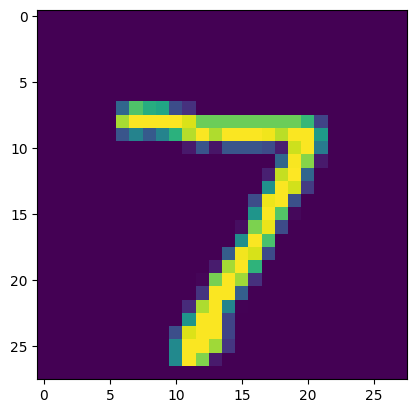

Model Name: AnalogSequential
Per-layer Information
Layer Information                                                     | Tile Information              
Layer Name          Is Analog           In Shape            Out Shape           Kernel Shape        # of Tiles          Reuse Factor        Log. tile shape     Phys. tile shape    utilization (%)     
AnalogConv2d        analog              [1, 1, 28, 28]      [1, 16, 24, 24]     (5, 5)              1                   576                 -                   -                   -                   
                                                                                                                                            (16, 25)            N/A                 100.00              
Tanh                digital             [1, 16, 24, 24]     [1, 16, 24, 24]     -                   0                   0                   -                   -                   -                   
MaxPool2d           digital             [1

In [9]:
test_loader = get_test_loader_2()

sample, _ = next(iter(test_loader))
sample = sample[0]
sample = sample.permute(1, 2, 0)

print(" Sample dimensions: ", sample.shape)
# Standardize the sample values in the range [0, 1]
sample = (sample - sample.min()) / (sample.max() - sample.min())
plt.imshow(sample)
plt.show()
print(analog_summary(model, (1, sample.shape[2], sample.shape[0], sample.shape[1]), rpu_config=InferenceRPUConfig()))



In [10]:
# Plot the histogram of the weights of the first model
tile_weights = next(model.analog_tiles()).get_weights()
pl.plot_tensor_values(tile_weights[0], 101, (-.8,.8), "Distribution of weights - Conv1 - LENET", "lenet/plots/hist_lenet_UNQUANTIZED_Conv1.png")

# Plot the histogram of the weights of the second model
tile_weights = next(model_9.analog_tiles()).get_weights()
pl.plot_tensor_values(tile_weights[0], 101, (-.8,.8), "Distribution of quantized weights - Conv1 - LENET9", "lenet/plots/hist_lenet_QUANTIZED_9_Conv1.png")


# Plot the histogram of the weights of the last model
tile_weights = next(model_17.analog_tiles()).get_weights()
pl.plot_tensor_values(tile_weights[0], 101, (-.8,.8), "Distribution of quantized weights - Conv1 - LENET17", "lenet/plots/hist_lenet_QUANTIZED_17_Conv1.png")


((array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0., 25.,  0.,  0.,  0., 12.,  0.,  0.,
          0., 16.,  0.,  0.,  0., 23.,  0.,  0.,  0., 29.,  0.,  0., 16.,
          0.,  0.,  0., 19.,  0.,  0.,  0., 28.,  0.,  0.,  0., 33.,  0.,
          0.,  0., 27.,  0.,  0.,  0., 36.,  0.,  0.,  0., 33.,  0.,  0.,
         28.,  0.,  0.,  0., 28.,  0.,  0.,  0., 21.,  0.,  0.,  0., 11.,
          0.,  0.,  0., 15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([-0.80000001, -0.78415841, -0.76831681, -0.75247526, -0.73663366,
         -0.72079206, -0.70495051, -0.68910891, -0.6732673 , -0.65742576,
         -0.64158416, -0.62574255, -0.60990101, -0.59405941, -0.5782178 ,
         -0.56237626, -0.54653466, -0.53069305, -0.51485151, -0.49900991,
         -0.4831683 , -0.46732673, -0.45148516, -0.43564355, -0.41980198,
         -0.40396041, -0.3881188 , -0.37227723, -0.

#### Evaluate the model accuracy on the test set.

In [11]:
def test_evaluation(model,validation_data, device):
    """Test trained network.

    Args:
        validation_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss

    Returns:
        nn.Module, float, float, float:  model, loss, error, and accuracy
    """
    predicted_ok = 0
    total_images = 0

    model.eval()

    for images, labels in validation_data:
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)

        _, predicted = torch.max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()
        accuracy = predicted_ok / total_images * 100
        error = (1 - predicted_ok / total_images) * 100


    return error, accuracy

Accuracy values:
Model 0:  98.92999999999999
Model 1:  98.79
Model 2:  98.87


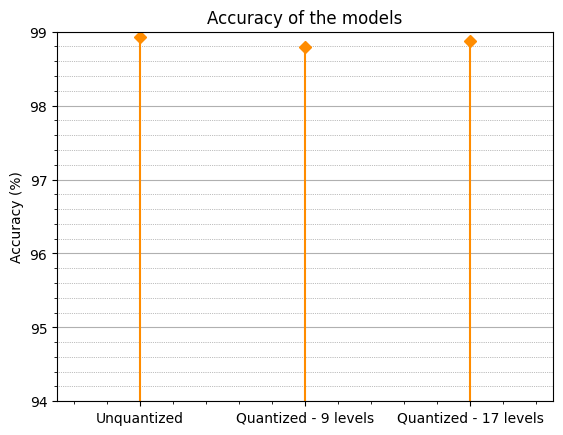

In [12]:
# Plot the accuracy of the models in a stem plot
fig, ax = plt.subplots()
models = ['Unquantized', 'Quantized - 9 levels', 'Quantized - 17 levels']
accuracies = [test_evaluation(model, test_loader, device)[1], test_evaluation(model_9, test_loader, device)[1], test_evaluation(model_17, test_loader, device)[1]]
print("Accuracy values:")
for i in range(len(accuracies)):
    print(f"Model {i}: ", accuracies[i])
# Get the mean of the accuracies and the standard deviation
mean = np.mean(accuracies)
std = np.std(accuracies)
ax.stem(models, accuracies, linefmt ='darkorange', markerfmt ='D', basefmt=' ')
ax.set_title("Accuracy of the models")
ax.set_ylabel("Accuracy (%)")
#ax.set_ylim([mean - 2*std, mean + 2*std])
ax.set_xlim([-0.5, len(models)- 0.5])
ax.minorticks_on()
ax.yaxis.grid(True)
ax.yaxis.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax.set_ylim([94, 99])
# Save the plot to file
plt.savefig("lenet/plots/accuracy_lenet_noNoise.png")
plt.show()



#### Add Gaussian Noise to the weights at programming time
---
Since using the built-in conversion function does not allow to actaully change the type of tile from FP tiles to Inferece tiles (which take into account the hardware non-idealities), leading  to conversion problems when trying to program the weights, we rebuild the model from scratch using the InferenceRPUConfig and _forcefully_ set the weights.

We will then proceed to add Gaussian noise to the weights at programming time and evaluate the model accuracy on the test set.

In [13]:
from src.noise import TestNVMNoiseModel
from aihwkit.inference.converter.conductance import SinglePairConductanceConverter
RPU_CONFIG  = InferenceRPUConfig(forward=IOParameters(is_perfect=True),
                                    noise_model=TestNVMNoiseModel(prog_std=5,
                                                                  g_converter=SinglePairConductanceConverter(g_max=40.)),
                                    clip= WeightClipParameter(type=WeightClipType.NONE,),
                                    remap= WeightRemapParameter(type=WeightRemapType.NONE,),
                                    modifier= WeightModifierParameter(type=WeightModifierType.NONE,), 
                                    drift_compensation=None,
                                    )


'''UNQUANTIZED'''
model_new = inference_lenet5(RPU_CONFIG).to(device)
model_new.load_state_dict(state_dict, strict=True, load_rpu_config=False)
original_model = inference_lenet5(RPU_CONFIG).to(device)
original_model.load_state_dict(state_dict, strict=True, load_rpu_config=False)
model_new.eval() 
model_new.program_analog_weights()

# Plot the histogram of the weights
pl.generate_moving_hist(model_new,title="Distribution of Weight + GNoise\n Values over the tiles - LENET", file_name="lenet/plots/hist_lenet_UNQUANTIZED_NOISE.gif", range = (-.7,.7), top=None, split_by_rows=False)

# Do the same for the quantized models:
'''QUANTIZED 9 levels'''
RPU_CONFIG.quantization = WeightQuantizerParameter(
    resolution=0.18,
    levels = 9,
)
model_new_9 = convert_to_analog(original_model, RPU_CONFIG)
model_new_9.eval()
model_new_9.program_analog_weights()


# Plot the histogram of the weights of the last model
tile_weights = next(model_new_9.analog_tiles()).get_weights()
pl.plot_tensor_values(tile_weights[0], 101, (-.8,.8), "Distribution of quantized weights + GNoise - Conv1 - LENET9", "lenet/plots/hist_lenet_QUANTIZED_9+NOISE_Conv1.png")



pl.generate_moving_hist(model_new_9,title="Distribution of Quantized Weight + GNoise\n Values over the tiles - LENET9", file_name="lenet/plots/hist_lenet_QUANTIZED_9_NOISE.gif", range = (-.7,.7), top=None, split_by_rows=False)

'''QUANTIZED 17 levels'''
RPU_CONFIG.quantization = WeightQuantizerParameter(
    resolution=0.12,
    levels = 17
)
model_new_17 = convert_to_analog(original_model, RPU_CONFIG)
model_new_17.eval()
model_new_17.program_analog_weights()

pl.generate_moving_hist(model_new_17,title="Distribution of Quantized Weight + GNoise\n Values over the tiles - LENET17", file_name="lenet/plots/hist_lenet_QUANTIZED_17_NOISE.gif", range = (-.7,.7), top=None, split_by_rows=False)

TypeError: TestNVMNoiseModel.__init__() missing 2 required positional arguments: 'file_path' and 'type'

NameError: name 'model_new' is not defined

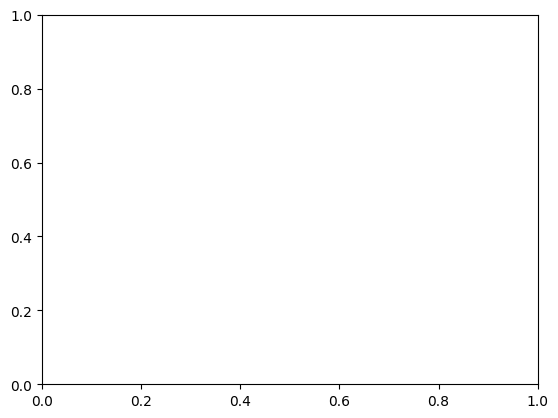

In [13]:
# Plot the accuracy of the models in a stem plot

fig, ax = plt.subplots()
models = ['Unquantized +\n Noise', 'Quantized - 9 levels\n + Nose', 'Quantized - 17 levels\n + Noise']
accuracies = [test_evaluation(model_new, test_loader, device)[1], test_evaluation(model_new_9, test_loader, device)[1], test_evaluation(model_new_17, test_loader, device)[1]]
# Get the mean of the accuracies and the standard deviation
mean = np.mean(accuracies)
std = np.std(accuracies)
ax.stem(models, accuracies, linefmt ='darkorange', markerfmt ='D', basefmt=' ')
ax.set_title("Accuracy of the models")
ax.set_ylabel("Accuracy (%)")
#ax.set_ylim([mean - 2*std, mean + 2*std])
ax.set_xlim([-0.5, len(models)- 0.5])
ax.minorticks_on()
ax.yaxis.grid(True)
ax.yaxis.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax.set_ylim([94, 99])

# Save the plot to file
plt.savefig("lenet/plots/accuracy_lenet_Noise.png")
plt.show()

#### Conductance values
---

As a last check, we will plot how the weights of the quantized LeNet at 9 levels are then converted to conductances.
The max. conductance is set to 40muS: the conversion whould take the maximum weight value in the tile and assign it to the maximum conductance value. All the other weights are ported to the conductance scale accordingly.

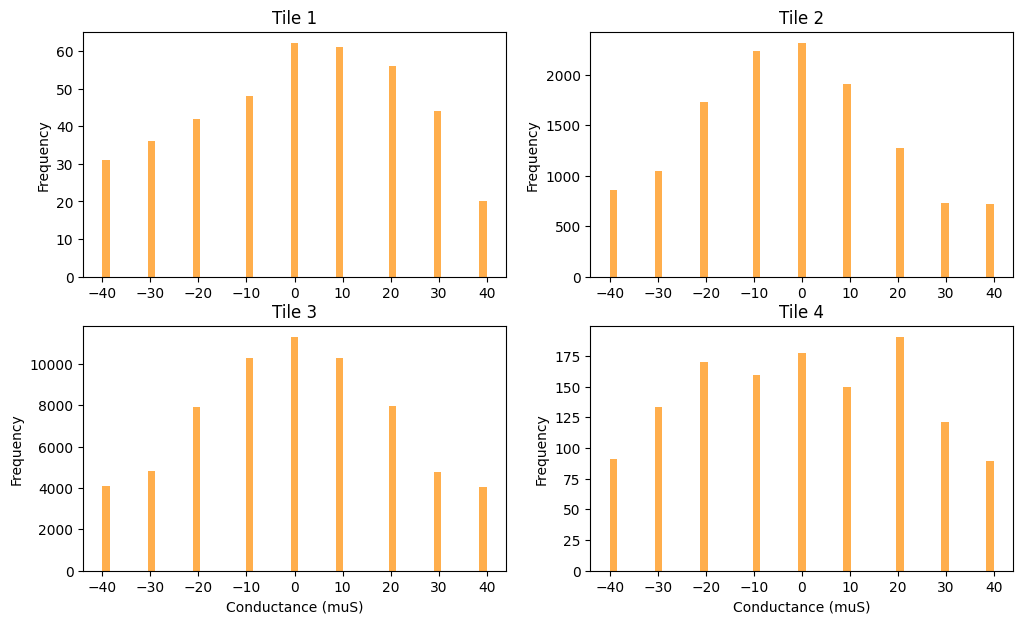

In [29]:
g_converter = SinglePairConductanceConverter(g_max=40.0)
fig, ax = plt.subplots(2,2, figsize=(12,7))

for i,tile_weights in enumerate(model_9.analog_tiles()):
    analog_weights,_ = tile_weights.get_weights()
    g_tuple = g_converter.convert_to_conductances(analog_weights)
    # for l in range(g_tuple[0][0].shape[0]):
    #     for k in range(g_tuple[0][0].shape[1]):
    #         if g_tuple[0][0][l,k] > 0 and g_tuple[0][1][l,k] > 0:
    #             ValueError("Both positive")
    ax[i//2,i%2].hist((g_tuple[0][0] - g_tuple[0][1]).flatten(), bins=51, range=(-40,40), alpha=0.7, color= 'darkorange')
    ax[i//2,i%2].set_title(f"Tile {i+1}")
    if i//2 == 1:
        ax[i//2,i%2].set_xlabel("Conductance (muS)")
    ax[i//2,i%2].set_ylabel("Frequency")
# Save the plot to file
plt.savefig("lenet/plots/Conductance_distribution_9_levels.png")



#### Fit the experimental data
---

We will now use some experimental data, collected from conductances in the range -40muS to 40muS, to estimate the accuracy of the quantized models when considered in a more realistic framework. Specifically, the data represents the values of said conductances when considering 9 and 17 levels of quantization (median and std deviation) after the programming of the weights, at different drift times and under different temperature conditions.

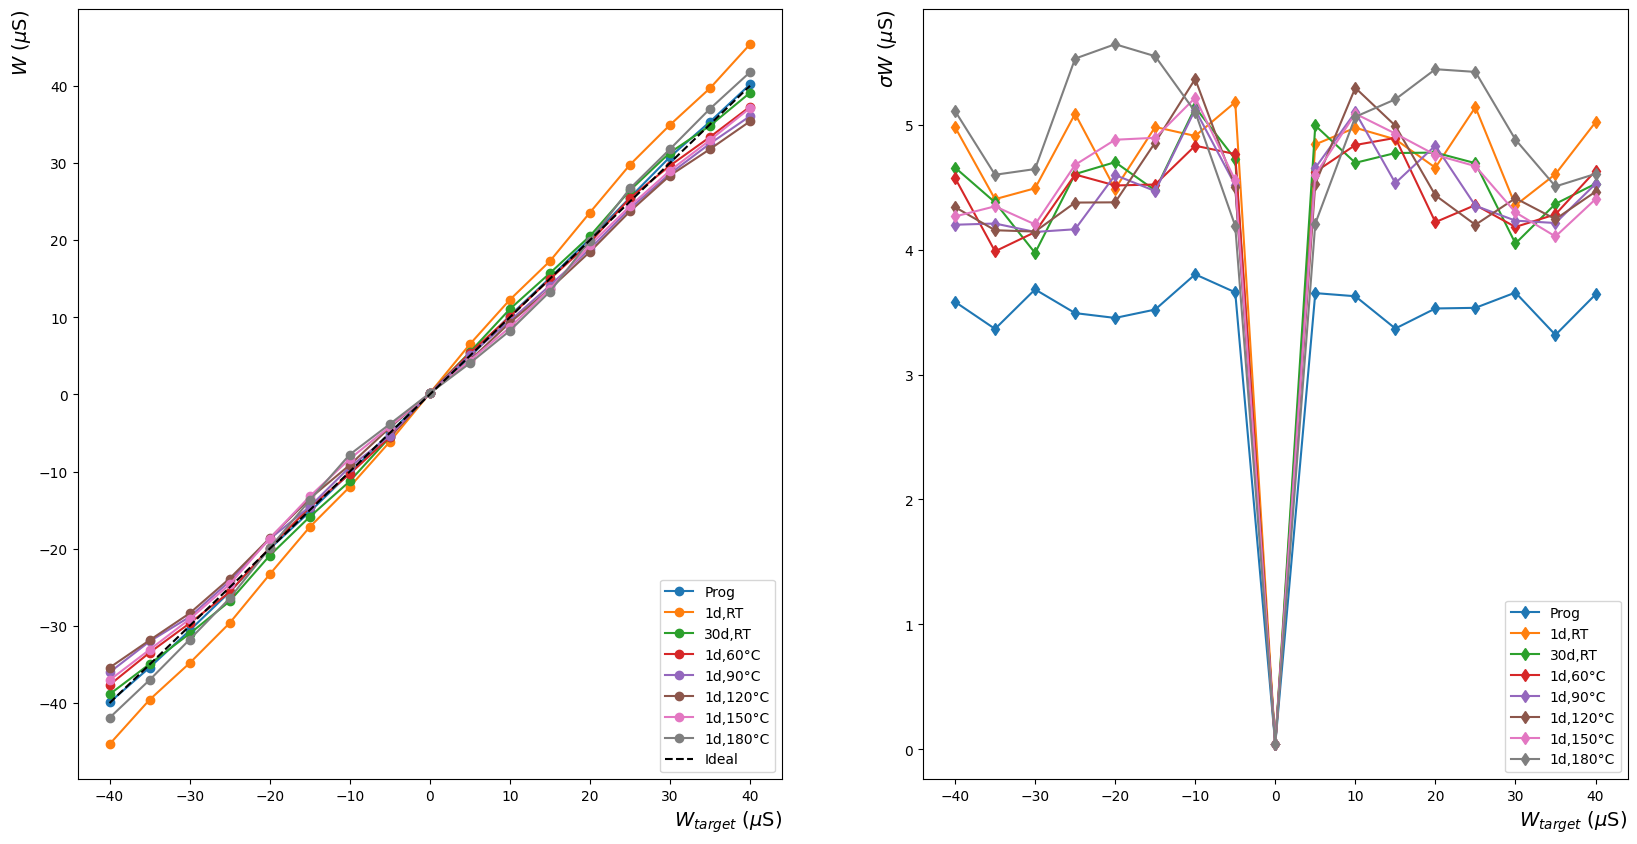

In [2]:
from src.utilities import import_mat_file

SELECTED_LEVEL = 17

MAP = {
    9 : "matlab/3bit.mat",
    17 : "matlab/4bit.mat",
}

G_RANGE = [-40, 40]
CONDUCTANCES = {
    9 : [G_RANGE[0] + i * (G_RANGE[1] - G_RANGE[0]) / 8 for i in range(9)],
    17 : [G_RANGE[0] + i * (G_RANGE[1] - G_RANGE[0]) / 16 for i in range(17)]
}

# Extract the data from the .mat file
path = f"./data/{MAP[SELECTED_LEVEL]}"
variables = import_mat_file(path)

types = variables['str']
ww_mdn = variables['ww_mdn'] * 1e6
ww_std = variables['ww_std'] * 1e6
ww_mdn = pd.DataFrame(ww_mdn, columns=types)
ww_std = pd.DataFrame(ww_std, columns=types)


fig, ax = plt.subplots(1,2, figsize=(20,10))
for type in types:
    ax[0].plot(CONDUCTANCES[SELECTED_LEVEL], ww_mdn[type], label=type, marker='o')
    ax[1].plot(CONDUCTANCES[SELECTED_LEVEL], ww_std[type], label=type, marker='d')
ax[0].plot(CONDUCTANCES[SELECTED_LEVEL], CONDUCTANCES[SELECTED_LEVEL] , label="Ideal", linestyle='--', color='black')
ax[0].set_ylabel(r" $W$ ($\mu$S)", fontsize=14, loc = 'top')
ax[1].set_ylabel(r" $\sigma W$ ($\mu$S)", fontsize=14, loc = 'top')
ax[0].set_xlabel(r" $W_{target}$ ($\mu$S)", fontsize=14, loc = 'right')
ax[1].set_xlabel(r" $W_{target}$ ($\mu$S)", fontsize=14, loc = 'right')
ax[0].set_yticks(np.arange(-40, 41, 10))
ax[0].legend(loc='lower right')
ax[1].legend(loc = 'lower right')


### Testing for the dumb compensation function
---


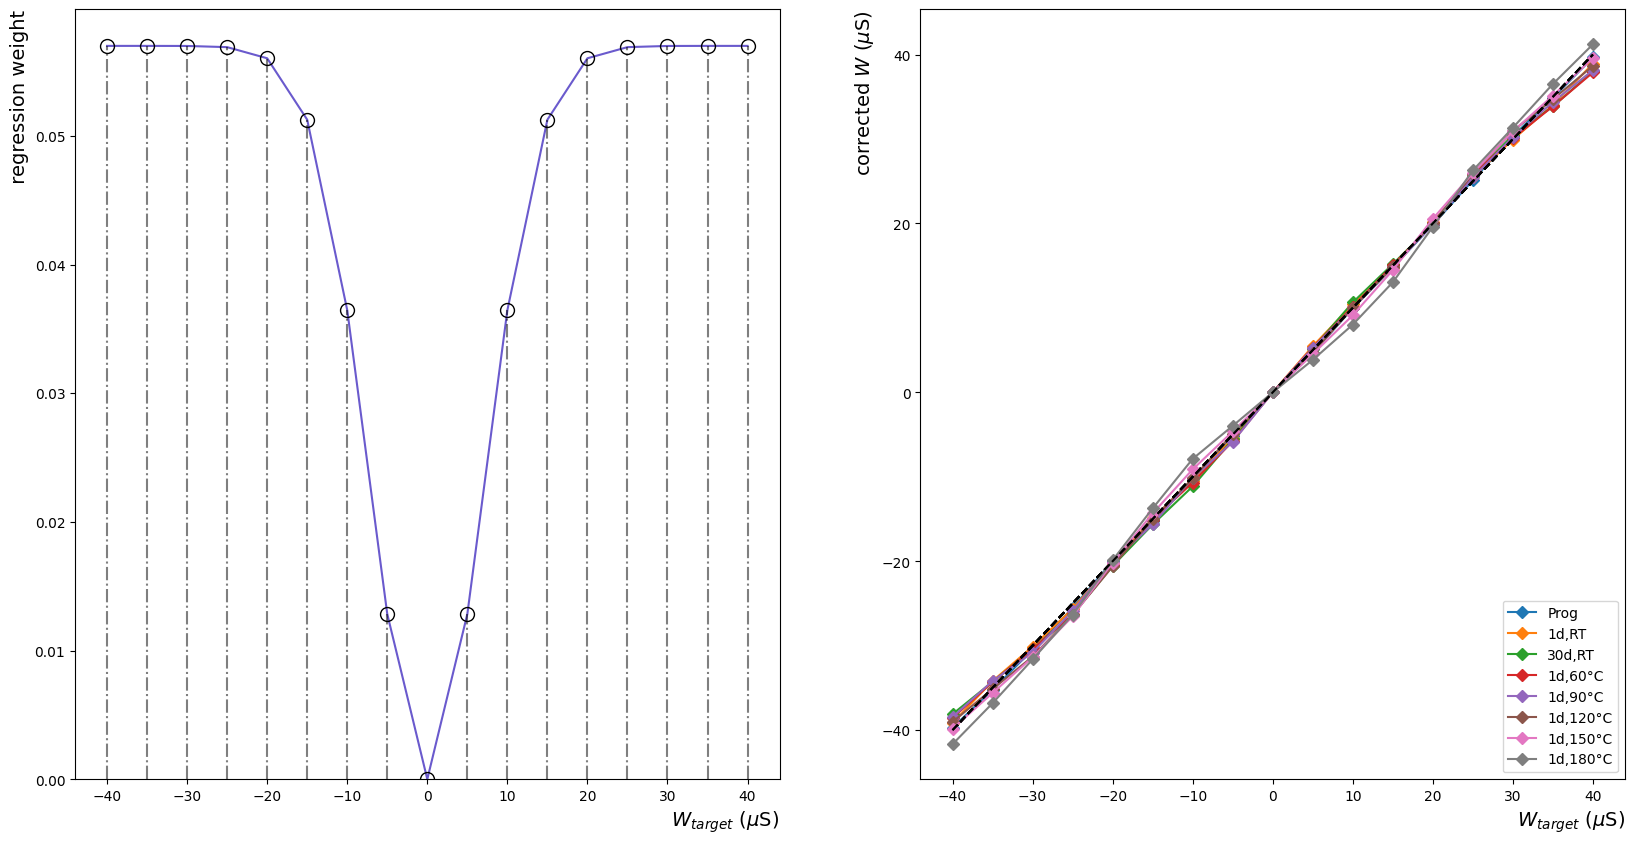

In [11]:
from src.utilities import correct
from scipy import stats

# Correct the data and plot again
fig, ax = plt.subplots(1,2, figsize=(20,10))
x = CONDUCTANCES[SELECTED_LEVEL]

# -- UNIFORM --
# weights = stats.uniform.pdf(np.linspace(-40, 40, SELECTED_LEVEL), -40, 80)
# weights_plot = weights.max() - weights + weights.min()
# -- CHI2 --
# weights = stats.chi2.pdf(np.linspace(0, 40, int(SELECTED_LEVEL/2)+1), 2, 0, 6)
# weights = np.concatenate((weights[:-1], weights[::-1]), axis= 0)
# weights_plot = weights.max() - weights + weights.min()
# -- GAUSSIAN --
weights = stats.norm.pdf(np.linspace(-40, 40, SELECTED_LEVEL), 0, 7)
weights_plot = weights
weights = (weights.max() - weights) + weights.min()


# plot weights
ax[0].plot(np.linspace(-40, 40, SELECTED_LEVEL), weights, marker = "o", color = "slateblue", markeredgecolor = "black", markerfacecolor = "None", markersize= "10")
ax[0].vlines(x = np.linspace(-40, 40, SELECTED_LEVEL), ymin=0, ymax = weights, color = "black", linestyle = "-.", alpha = 0.5)
ax[0].set_xlabel(r" $W_{target}$ ($\mu$S)", fontsize=14, loc = 'right')
ax[0].set_ylabel(r" regression weight", fontsize=14, loc = 'top')
ax[0].set_ylim(bottom=0)


for type in types:
    y = ww_mdn[type]
    y = correct(x, y, weights=weights)
    ax[1].plot(x, y, label=type, marker='D')
    ax[1].plot(x,x, linestyle='--', color='black')
ax[1].set_ylabel(r" corrected $W$ ($\mu$S)", fontsize=14, loc = 'top')
ax[1].set_xlabel(r" $W_{target}$ ($\mu$S)", fontsize=14, loc = 'right')
ax[1].legend(loc='lower right')

    


Available experimental noises are:  ['Prog', 'Read', '7d @RT', '60d @RT', '120d @RT', '24h @90°C', '24h @120°C', '24h @150°C', '24h @180°C']
Chosen noise: Prog
Selected level: 9






















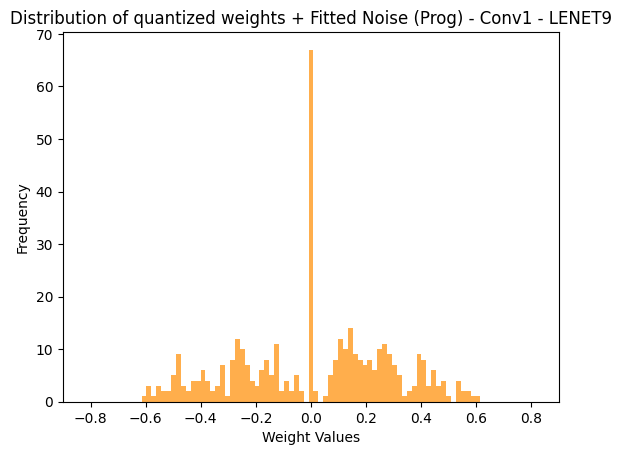

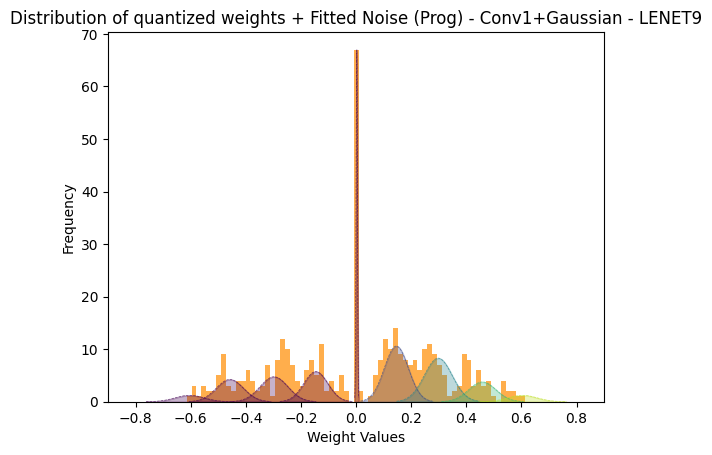

<Figure size 640x480 with 0 Axes>

In [ ]:
from src.noise import ExperimentalNoiseModel
from aihwkit.inference.converter.conductance import SinglePairConductanceConverter

print("Available experimental noises are: ", types)
CHOSEN_NOISE = types[0]
print(f"Chosen noise: {CHOSEN_NOISE}" )
path = f"./data/{MAP[SELECTED_LEVEL]}"
print(f"Selected level: {SELECTED_LEVEL}")

RPU_CONFIG  = InferenceRPUConfig(forward=IOParameters(is_perfect=True),
                                    noise_model=ExperimentalNoiseModel(file_path = path,
                                                                       type = CHOSEN_NOISE,
                                                                       g_converter=SinglePairConductanceConverter(g_max=40.)),
                                    clip= WeightClipParameter(type=WeightClipType.NONE,),
                                    remap= WeightRemapParameter(type=WeightRemapType.NONE,),
                                    modifier= WeightModifierParameter(type=WeightModifierType.NONE,), 
                                    drift_compensation=None,
                                    )

original_model = inference_lenet5(RPU_CONFIG).to(device)
original_model.load_state_dict(state_dict, strict=True, load_rpu_config=False)

'''QUANTIZED 9 levels'''
RPU_CONFIG.quantization = WeightQuantizerParameter(
    resolution=0.18 if SELECTED_LEVEL == 9 else 0.12,
    levels = SELECTED_LEVEL,
)
model_fitted = convert_to_analog(original_model, RPU_CONFIG)
model_fitted.eval()
model_fitted.program_analog_weights()


# Plot the histogram of the weights of the last model
tile_weights = next(model_fitted.analog_tiles()).get_weights()

gaussain_noise = {"means": ww_mdn[CHOSEN_NOISE].values, "stds": ww_std[CHOSEN_NOISE].values, "gmax": 40.0}
pl.plot_tensor_values(tile_weights[0], 101, (-.9,.9), f"Distribution of quantized weights + Fitted Noise ({CHOSEN_NOISE}) - Conv1 - LENET{SELECTED_LEVEL}", f"lenet/plots/hist_lenet_QUANTIZED_{SELECTED_LEVEL}+FITTED_Conv1.png")
pl.plot_tensor_values(tile_weights[0], 101, (-.9,.9), f"Distribution of quantized weights + Fitted Noise ({CHOSEN_NOISE}) - Conv1+Gaussian - LENET{SELECTED_LEVEL}", f"lenet/plots/hist_lenet_QUANTIZED_{SELECTED_LEVEL}+FITTED_Conv1+Gaussian.png", gaussian=gaussain_noise)



pl.generate_moving_hist(model_fitted,title=f"Distribution of Quantized Weight + Fitted Noise ({CHOSEN_NOISE})\n Values over the tiles - LENET{SELECTED_LEVEL}", file_name=f"lenet/plots/hist_lenet_QUANTIZED_{SELECTED_LEVEL}_FITTED.gif", range = (-.7,.7), top=None, split_by_rows=False)


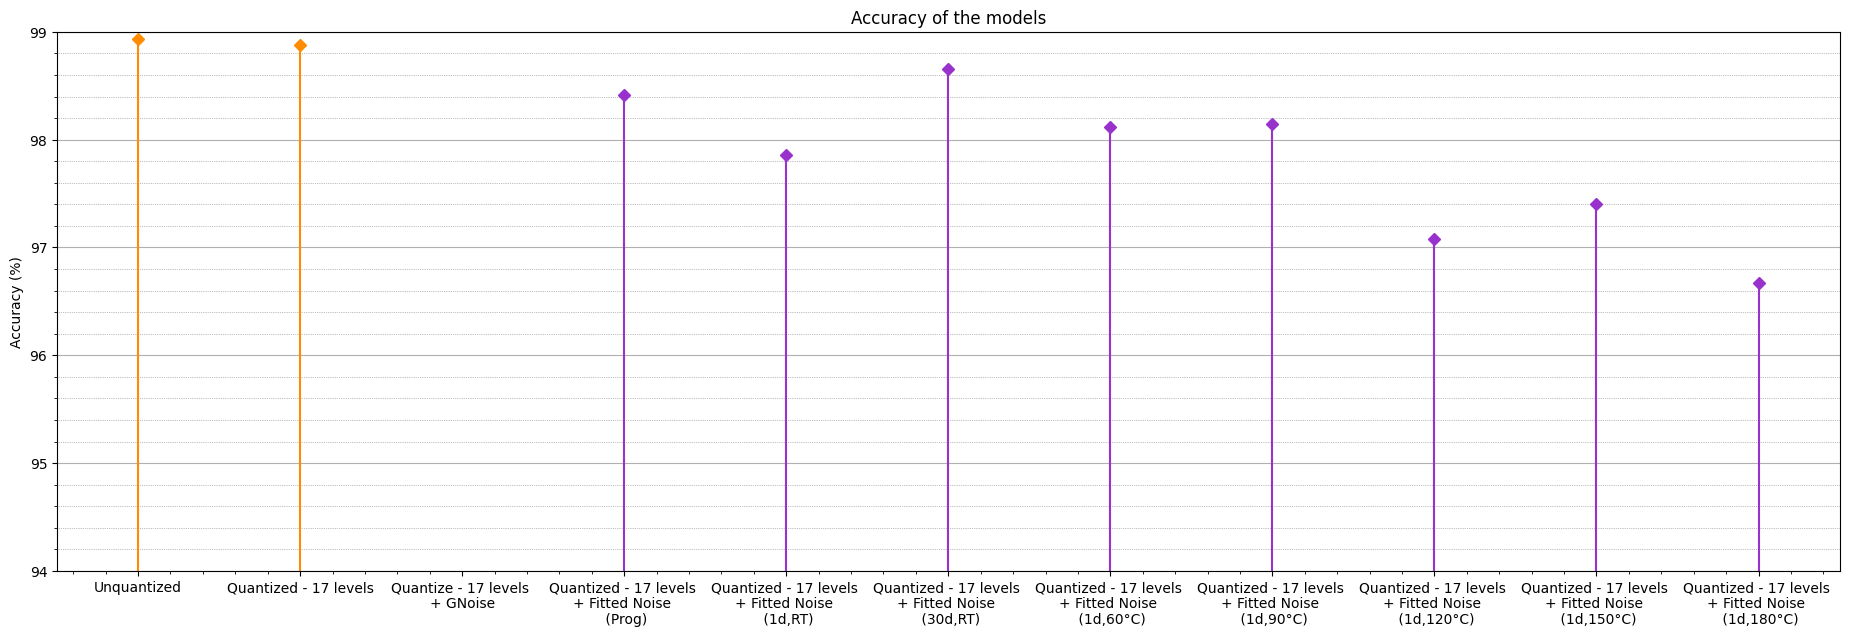

In [ ]:
# Estimate the accuracy of the model with the fitted noise with respect to the other 9 levels model
fitted_models_names = []
fitted_models_accuracy = []
for i in range(len(types)):
    CHOSEN_NOISE = types[i]
    RPU_CONFIG  = InferenceRPUConfig(forward=IOParameters(is_perfect=True),
                                    noise_model=ExperimentalNoiseModel(file_path = path,
                                                                       type = CHOSEN_NOISE,
                                                                       g_converter=SinglePairConductanceConverter(g_max=40.)),
                                    clip= WeightClipParameter(type=WeightClipType.NONE,),
                                    remap= WeightRemapParameter(type=WeightRemapType.NONE,),
                                    modifier= WeightModifierParameter(type=WeightModifierType.NONE,), 
                                    drift_compensation=None,
                                    )

    original_model = inference_lenet5(RPU_CONFIG).to(device)
    original_model.load_state_dict(state_dict, strict=True, load_rpu_config=False)

    RPU_CONFIG.quantization = WeightQuantizerParameter(
        resolution=0.18 if SELECTED_LEVEL == 9 else 0.12,
        levels = SELECTED_LEVEL,
    )
    model_fitted = convert_to_analog(original_model, RPU_CONFIG)
    model_fitted.eval()
    model_fitted.program_analog_weights()
    #fitted_models.append(model_fitted_9)
    fitted_models_names.append(f"Quantized - {SELECTED_LEVEL} levels \n+ Fitted Noise \n ({CHOSEN_NOISE})")
    fitted_models_accuracy.append(test_evaluation(model_fitted, test_loader, device)[1])

fig, ax = plt.subplots(figsize=(23,7))
models = ["Unquantized",f"Quantized - {SELECTED_LEVEL} levels",f"Quantize - {SELECTED_LEVEL} levels \n+ GNoise"] + fitted_models_names
if SELECTED_LEVEL == 9:
    accuracies = [test_evaluation(model, test_loader, device)[1], test_evaluation(model_9, test_loader, device)[1], test_evaluation(model_new_9, test_loader, device)[1]]
else:
    accuracies = [test_evaluation(model, test_loader, device)[1], test_evaluation(model_17, test_loader, device)[1], test_evaluation(model_new_17, test_loader, device)[1]]
accuracies = accuracies + fitted_models_accuracy
ax.stem(models[:3], accuracies[:3], linefmt ='darkorange', markerfmt ='D', basefmt=' ')
ax.stem(models[3:], accuracies[3:], linefmt ='darkorchid', markerfmt ='D', basefmt=' ')
ax.set_title("Accuracy of the models")
ax.set_ylabel("Accuracy (%)")
ax.set_xlim([-0.5, len(models)- 0.5])
ax.minorticks_on()
ax.yaxis.grid(True)
ax.yaxis.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax.set_ylim([94, 99])
# Save the plot to file
plt.savefig(f"lenet/plots/accuracy_lenet_FittedNoise_{SELECTED_LEVEL}.png")
plt.show()

### Ex.3:    ResNet9
---

We will now consider a model inspired by the ResNet9 architecture and the CIFAR-10 dataset. The model has been pretrained on the CIFAR-10 dataset in an hardware-aware fashion. We will convert the model to analog and quantize the weights using the newly implemented quantization functions.

In [ ]:
%matplotlib inline
import os
import torch
from torch import nn, Tensor, device, no_grad, manual_seed
from torch import nn
from torchvision.datasets.utils import download_url
import torch.nn.functional as F
from torchmetrics.functional import accuracy
import torchvision
from torchvision import datasets, transforms
from torch.nn.functional import mse_loss

# Import functions defined in a specific path
import sys
sys.path.append('../src/')


from aihwkit.simulator.configs import ConstantStepDevice, SingleRPUConfig, FloatingPointDevice, FloatingPointRPUConfig
from aihwkit.optim import AnalogSGD
from aihwkit.inference.noise.base import BaseNoiseModel
from aihwkit.inference.noise.pcm import PCMLikeNoiseModel
from aihwkit.inference.compensation.drift import GlobalDriftCompensation
from aihwkit.inference.compensation.base import BaseDriftCompensation
from aihwkit.simulator.configs import InferenceRPUConfig
from aihwkit.simulator.presets.utils import PresetIOParameters
from aihwkit.simulator.parameters import (
    MappingParameter,
    IOParameters,
    PrePostProcessingParameter,
    InputRangeParameter,
    WeightClipParameter,
    WeightRemapParameter,
    WeightModifierParameter,
    WeightQuantizerParameter,
)
from aihwkit.simulator.parameters.enums import (
    WeightClipType,
    BoundManagementType,
    NoiseManagementType,
    WeightNoiseType,
    WeightRemapType,
    WeightModifierType,
)
from aihwkit.nn import AnalogLinearMapped, AnalogConv2d, AnalogSequential, AnalogLinear
# from aihwkit.utils.visualization import plot_device_compact
# from aihwkit.utils.analog_info import analog_summary
# from aihwkit.utils.fitting import fit_measurements
from aihwkit.nn.conversion import convert_to_analog
from aihwkit.utils.analog_info import analog_summary
from aihwkit.inference.calibration import (
    calibrate_input_ranges,
    InputRangeCalibrationType,
)
#from aihwkit.simulator.rpu_base import cuda

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dataclasses import dataclass, field
from typing import Optional

import src.plotting as pl

device = torch.device("cpu")


from src.utilities import import_mat_file
SELECTED_LEVEL = 9

MAP = {
    9 : "matlab/3bit.mat",
    17 : "matlab/4bit.mat",
}

G_RANGE = [-40, 40]
CONDUCTANCES = {
    9 : [G_RANGE[0] + i * (G_RANGE[1] - G_RANGE[0]) / 8 for i in range(9)],
    17 : [G_RANGE[0] + i * (G_RANGE[1] - G_RANGE[0]) / 16 for i in range(17)]
}

# Extract the data from the .mat file
path = f"./data/{MAP[SELECTED_LEVEL]}"
variables = import_mat_file(path)

types = variables['str']
types = [types[0][t][0] for t in range(types.shape[1])]
ww_mdn = variables['ww_mdn'] * 1e6
ww_std = variables['ww_std'] * 1e6
ww_mdn = pd.DataFrame(ww_mdn, columns=types)
ww_std = pd.DataFrame(ww_std, columns=types)



In [ ]:
class LambdaLayer(torch.nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

# Definitions of some building blocks for the ResNet, taken form example '18_cifar10_on_resnet.ipynb'
class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option="A"):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = torch.nn.BatchNorm2d(planes)

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == "A":
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::2, ::2],
                        (0, 0, 0, 0, planes // 4, planes // 4),
                        "constant",
                        0,
                    )
                )
            elif option == "B":
                self.shortcut = torch.nn.Sequential(
                    torch.nn.Conv2d(
                        in_planes,
                        self.expansion * planes,
                        kernel_size=1,
                        stride=stride,
                        bias=False,
                    ),
                    torch.nn.BatchNorm2d(self.expansion * planes),
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Resnet9(torch.nn.Module):
    """
    From https://github.com/matthias-wright/cifar10-resnet/
    """

    def __init__(self, channels):
        super(Resnet9, self).__init__()

        self.channels = channels

        # resnet9 [56,112,224,224]
        # resnet9s [28,28,28,56]

        self.bn1 = torch.nn.BatchNorm2d(num_features=channels[0], momentum=0.9)
        self.bn2 = torch.nn.BatchNorm2d(num_features=channels[1], momentum=0.9)
        self.bn3 = torch.nn.BatchNorm2d(num_features=channels[2], momentum=0.9)
        self.bn4 = torch.nn.BatchNorm2d(num_features=channels[3], momentum=0.9)

        self.conv = torch.nn.Sequential(
            # prep
            torch.nn.Conv2d(
                in_channels=3,
                out_channels=channels[0],
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            self.bn1,
            torch.nn.ReLU(inplace=True),
            # Layer 1
            torch.nn.Conv2d(
                in_channels=channels[0],
                out_channels=channels[1],
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            self.bn2,
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            BasicBlock(in_planes=channels[1], planes=channels[1], stride=1),
            # Layer 2
            torch.nn.Conv2d(
                in_channels=channels[1],
                out_channels=channels[2],
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            self.bn3,
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            # Layer 3
            torch.nn.Conv2d(
                in_channels=channels[2],
                out_channels=channels[3],
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            self.bn4,
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            BasicBlock(in_planes=channels[3], planes=channels[3], stride=1),
            torch.nn.MaxPool2d(kernel_size=4, stride=4),
        )

        self.fc = torch.nn.Linear(in_features=channels[3], out_features=10, bias=True)

    def forward(self, x):
        out = self.conv(x)
        out = out.view(-1, self.channels[3])
        out = self.fc(out)
        return out

def resnet9s():
    return Resnet9(channels=[28, 28, 28, 56])

def get_test_loader(batch_size=128):
    transform_test = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
            ),
        ]
    )
    testset = torchvision.datasets.CIFAR10(
        root="data/cifar10", train=False, download=True, transform=transform_test
    )
    test_loader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )
    return test_loader

from tqdm import tqdm

def evaluate_model(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in tqdm(test_loader, desc="Evaluating model"):

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        return 100.0 * correct / total
    

class Sampler:
    """Example of a sampler used for calibration."""

    def __init__(self, loader, device):
        self.device = device
        self.loader = iter(loader)
        self.idx = 0

    def __iter__(self):
        return self

    def __next__(self):
        x, _ = next(self.loader)
        self.idx += 1
        if self.idx > 100:
            raise StopIteration

        return ([x.to(self.device)], {})



#### Define a suitable RPU object
---
The following class is defined to set the RPU configuration for the ResNet9 model. The parameters are set in accordance to the way the ResNet9 model was trained in an hardware aware manner, to facilitate importing it into this notebook.

The class features are mainly taken form [StandardHWATrainingPreset](../src/aihwkit/simulator/presets/inference.py)
1. We set the ***mapping*** parameters, responsible for the mapping of the weights to the crossbar.
2. We set the ***forward*** parameters, responsible for the non-idealities at tile level.
3. We set the ***remap*** and ***clip*** parameters, responsible for the remapping ad clipping of the weights to the crossbar at each weight update during training, to ensure the weights are correctly mapped to appropriate conductances.
4. We set the ***drift*** parameters, responsible for the drift of the weights.
5. We set the ***pre-post*** parameters, responsible for the input range learning.
6. We set the ***noise_model*** parameters, to characterize the read noise for the weights in the device.

In [ ]:
@dataclass
class CustomDefinedPreset(InferenceRPUConfig):

    mapping: MappingParameter = field(
        default_factory=lambda: MappingParameter(
            weight_scaling_omega=1.0,
            weight_scaling_columnwise=False,
            max_input_size=512,
            max_output_size=0,
            digital_bias=True,
            learn_out_scaling=True,
            out_scaling_columnwise=True,
        )
    )

    forward: IOParameters = field(
        default_factory=lambda: PresetIOParameters(
            inp_res=254.0,
            out_res=254.0,
            bound_management=BoundManagementType.NONE,
            noise_management=NoiseManagementType.CONSTANT,
            nm_thres=1.0,
            #w_noise=0.0175,
            w_noise_type=WeightNoiseType.NONE,
            ir_drop=1.0,
            out_noise=0.04,
            out_bound=10.0,
        )
    )

    # remap: WeightRemapParameter = field(
    #     default_factory=lambda: WeightRemapParameter(
    #         remapped_wmax=1.0, type=WeightRemapType.CHANNELWISE_SYMMETRIC
    #     )
    # )

    #noise_model: BaseNoiseModel = field(default_factory=PCMLikeNoiseModel)

    # drift_compensation: Optional[BaseDriftCompensation] = field(
    #     default_factory=GlobalDriftCompensation
    # )

    pre_post: PrePostProcessingParameter = field(
        default_factory=lambda: PrePostProcessingParameter(
            # InputRangeParameter used for dynamic input range learning
            input_range=InputRangeParameter(
                enable=True,
                init_value=3.0,
                init_from_data=100,
                init_std_alpha=3.0,
                decay=0.001,
                input_min_percentage=0.95,
                output_min_percentage=0.95,
                manage_output_clipping=False,
                gradient_scale=1.0,
                gradient_relative=True,
            )
        )
    )

    # clip: WeightClipParameter = field(
    #     default_factory=lambda: WeightClipParameter(
    #         type=WeightClipType.FIXED_VALUE, fixed_value=1.0
    #     )
    # )

Using downloaded and verified file: /Users/edoardocabiati/Desktop/Cose_brutte_PoliMI/_tesi/aihwkit/sandboxresnet/resnet9s.th/resnet9s.th
0

	 resolution:	0
	 levels: 	0
	 quantize_last_column: 	1
	 stochastic_round: 	0
	 quantizer_type: 	Uniform
0

	 resolution:	0
	 levels: 	0
	 quantize_last_column: 	1
	 stochastic_round: 	0
	 quantizer_type: 	Uniform
0

	 resolution:	0
	 levels: 	0
	 quantize_last_column: 	1
	 stochastic_round: 	0
	 quantizer_type: 	Uniform
0

	 resolution:	0
	 levels: 	0
	 quantize_last_column: 	1
	 stochastic_round: 	0
	 quantizer_type: 	Uniform
0

	 resolution:	0
	 levels: 	0
	 quantize_last_column: 	1
	 stochastic_round: 	0
	 quantizer_type: 	Uniform
0

	 resolution:	0
	 levels: 	0
	 quantize_last_column: 	1
	 stochastic_round: 	0
	 quantizer_type: 	Uniform
0

	 resolution:	0
	 levels: 	0
	 quantize_last_column: 	1
	 stochastic_round: 	0
	 quantizer_type: 	Uniform
0

	 resolution:	0
	 levels: 	0
	 quantize_last_column: 	1
	 stochastic_round: 	0
	 quantizer_type: 

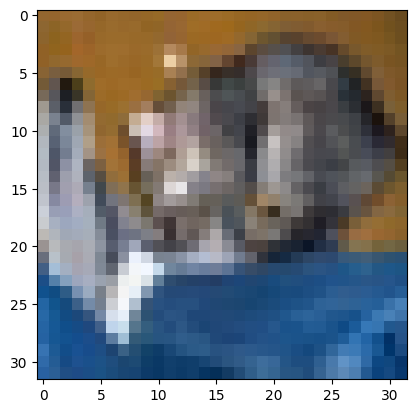

Model Name: AnalogWrapperResnet9
Per-layer Information
Layer Information                                                     | Tile Information              
Layer Name          Is Analog           In Shape            Out Shape           Kernel Shape        # of Tiles          Reuse Factor        Log. tile shape     Phys. tile shape    utilization (%)     
AnalogConv2d        analog              [1, 3, 32, 32]      [1, 28, 32, 32]     (3, 3)              1                   1024                -                   -                   -                   
                                                                                                                                            (28, 27)            N/A                 100.00              
BatchNorm2d         digital             [1, 28, 32, 32]     [1, 28, 32, 32]     -                   0                   0                   -                   -                   -                   
BatchNorm2d         digital           

<Figure size 640x480 with 0 Axes>

In [ ]:

# Create the model and load the weights
model = resnet9s().to(device)
cwd = os.getcwd()
os.mkdir("resnet") if not os.path.exists("resnet") else None
os.mkdir("resnet/plots") if not os.path.exists("resnet/plots") else None
download_url(
    "https://aihwkit-tutorial.s3.us-east.cloud-object-storage.appdomain.cloud/resnet9s.th",
    cwd + "resnet/resnet9s.th",
)
state_dict = torch.load("resnet/resnet9s.th", device)
# The state dict of the model with hardware-aware trained weights is stored in the
# model_state_dict key of the external checkpoint.
model.load_state_dict(state_dict["model_state_dict"], strict=True)
rpu_config = CustomDefinedPreset()
model = convert_to_analog(model, CustomDefinedPreset())
model.eval()

pl.generate_moving_hist(model,title="Distribution of Weight Values over the tiles - RESNET", file_name="resnet/plots/hist_resnet_UNQUATIZED.gif", range = (-.5,.5), top=None, split_by_rows=False, HIST_BINS = 171)


def get_quantized_model(level, rpu_config):
    rpu_config.quantization = WeightQuantizerParameter(
        resolution=0.12 if level == 17 else 0.2,
        levels=level
    )
    model_quantized = convert_to_analog(model, rpu_config)
    model_quantized.eval()
    return model_quantized
model_quantized = get_quantized_model(SELECTED_LEVEL, rpu_config)

# Load the test set
test_loader = get_test_loader()

# Plot specific dimension of a single instance in the test set and plot
# the sample
sample, _ = next(iter(test_loader))
sample = sample[0]
sample = sample.permute(1, 2, 0)
print(" Sample dimensions: ", sample.shape)
# Standardize the sample values in the range [0, 1]
sample = (sample - sample.min()) / (sample.max() - sample.min())
plt.imshow(sample)
plt.show()

# Get a summary of the analog model and plot the histogram of the weights
pl.generate_moving_hist(model_quantized,title= f"Distribution of Quantized Weight Values over the tiles - RESNET{SELECTED_LEVEL}", file_name=f"resnet/plots/hist_resnet_QUANTIZED_{SELECTED_LEVEL}.gif", range = (-.5,.5), top=None, split_by_rows=False, HIST_BINS = 171)
analog_summary(model_quantized, (1, sample.shape[2], sample.shape[0], sample.shape[1]), rpu_config=CustomDefinedPreset())



In [ ]:

t_inferences = [0.0]  # Times to perform infernece.
n_reps = 1  # Number of inference repetitions.
# Calibrate input ranges
print("Performing input range calibration")
models =[ model, get_quantized_model(9, rpu_config), get_quantized_model(17, rpu_config)]
for model in models:
    calibrate_input_ranges(
    model=model,
    calibration_type=InputRangeCalibrationType.CACHE_QUANTILE,
    dataloader=Sampler(test_loader, device),
    )

# Evaluate the three models
print("Evaluating the models")

model_names = ["Unquantized", "Quantized - 9 levels", "Quantized - 17 levels"]
inference_accuracy_values = torch.zeros((len(t_inferences), n_reps, len(models)))
for t_id, t in enumerate(t_inferences):
    for i, model in enumerate(models):
        for j in range(n_reps):
            inference_accuracy_values[t_id, j, i] = evaluate_model(
                model, test_loader, device
            )

        print(
            f"Test set accuracy (%) at t={t}s for {model_names[i]}: mean: {inference_accuracy_values[t_id, :, i].mean()}"
        )



Performing input range calibration


























































































Evaluating the models


Evaluating model: 100%|██████████| 79/79 [03:40<00:00,  2.79s/it]


Test set accuracy (%) at t=0.0s for Unquantized: mean: 79.52999877929688


Evaluating model: 100%|██████████| 79/79 [03:39<00:00,  2.78s/it]


Test set accuracy (%) at t=0.0s for Quantized - 9 levels: mean: 77.12000274658203


Evaluating model: 100%|██████████| 79/79 [03:37<00:00,  2.76s/it]


Test set accuracy (%) at t=0.0s for Quantized - 17 levels: mean: 79.33000183105469


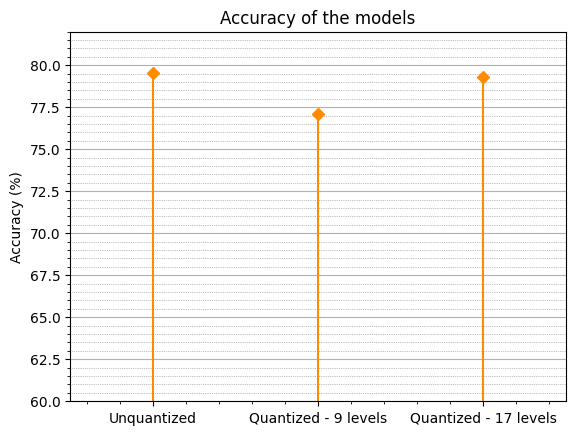

In [ ]:
# Plot the accuracy of the models in a stem plot
fig, ax = plt.subplots()
for i, model_name in enumerate(model_names):
    accuracies = inference_accuracy_values[0, :, i]
    mean = accuracies.mean()
    ax.stem([model_name], [mean], linefmt="darkorange", markerfmt="D", basefmt=" ")
ax.set_title("Accuracy of the models")
ax.set_ylabel("Accuracy (%)")
ax.set_xlim([-0.5, len(models) - 0.5])
ax.minorticks_on()
ax.yaxis.grid(True)
ax.yaxis.grid(which="minor", linestyle=":", linewidth="0.5", color="gray")
ax.set_ylim([60, 82])

# Save the plot to file
plt.savefig("resnet/plots/accuracy_resnet.png")

#### Add experimental data
---

Available experimental noises are:  ['Prog', 'Read', '7d @RT', '60d @RT', '120d @RT', '24h @90°C', '24h @120°C', '24h @150°C', '24h @180°C']
Chosen noise: Prog
Selected level: 9





























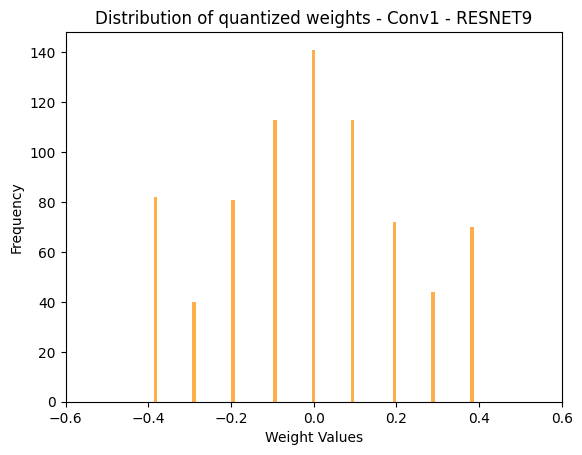

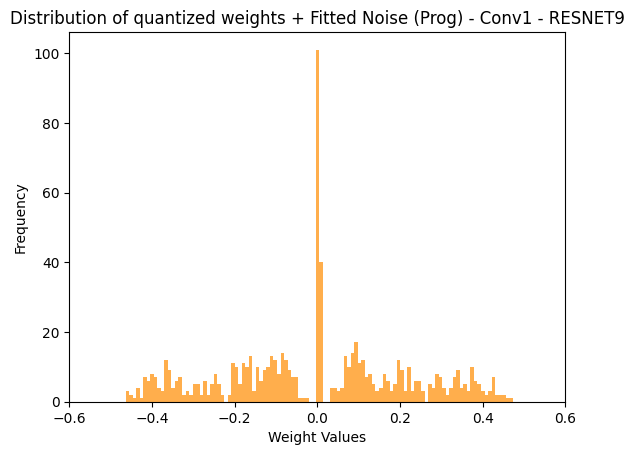

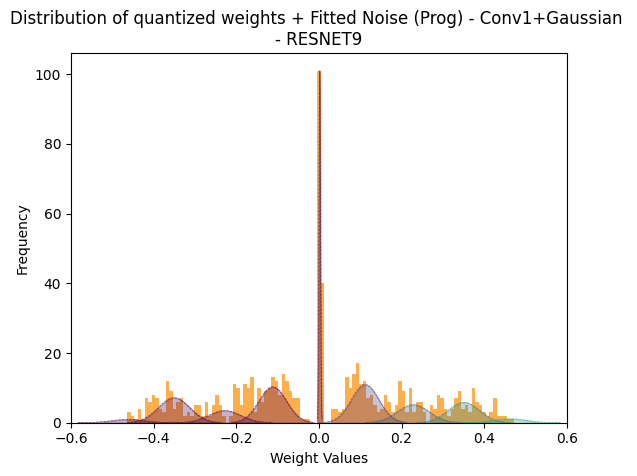

<Figure size 640x480 with 0 Axes>

In [ ]:
from src.noise import ExperimentalNoiseModel
from aihwkit.inference.converter.conductance import SinglePairConductanceConverter

print("Available experimental noises are: ", types)
CHOSEN_NOISE = types[0]
print(f"Chosen noise: {CHOSEN_NOISE}" )
path = f"./data/{MAP[SELECTED_LEVEL]}"
print(f"Selected level: {SELECTED_LEVEL}")

RPU_CONFIG  = CustomDefinedPreset()
RPU_CONFIG.noise_model=ExperimentalNoiseModel(file_path = path,
                                              type = CHOSEN_NOISE,
                                              g_converter=SinglePairConductanceConverter(g_max=40.)),
                   

original_model = resnet9s().to(device)
original_model.load_state_dict(state_dict["model_state_dict"], strict=True)

'''QUANTIZED 9 levels'''
RPU_CONFIG.quantization = WeightQuantizerParameter(
    resolution=0.2 if SELECTED_LEVEL == 9 else 0.12,
    levels = SELECTED_LEVEL,
)
model_fitted = convert_to_analog(original_model, RPU_CONFIG)
model_fitted.eval()
tile_weights = next(model_fitted.analog_tiles()).get_weights()
pl.plot_tensor_values(tile_weights[0], 141, (-.6,.6), f"Distribution of quantized weights - Conv1 - RESNET{SELECTED_LEVEL}", f"resnet/plots/hist_resnet_QUANTIZED_{SELECTED_LEVEL}_Conv1.png")
model_fitted.program_analog_weights()


# Plot the histogram of the weights of the last model
tile_weights = next(model_fitted.analog_tiles()).get_weights()
gaussain_noise = {"means": ww_mdn[CHOSEN_NOISE].values, "stds": ww_std[CHOSEN_NOISE].values, "gmax": 40.0}
pl.plot_tensor_values(tile_weights[0], 141, (-.6,.6), f"Distribution of quantized weights + Fitted Noise ({CHOSEN_NOISE}) - Conv1 - RESNET{SELECTED_LEVEL}", f"resnet/plots/hist_resnet_QUANTIZED_{SELECTED_LEVEL}+FITTED_Conv1.png")
pl.plot_tensor_values(tile_weights[0], 141, (-.6,.6), f"Distribution of quantized weights + Fitted Noise ({CHOSEN_NOISE}) - Conv1+Gaussian \n- RESNET{SELECTED_LEVEL}", f"resnet/plots/hist_resnet_QUANTIZED_{SELECTED_LEVEL}+FITTED_Conv1+Gaussian.png", gaussian=gaussain_noise)



pl.generate_moving_hist(model_fitted,title=f"Distribution of Quantized Weight + Fitted Noise ({CHOSEN_NOISE})\n Values over the tiles - RESNET{SELECTED_LEVEL}", file_name=f"resnet/plots/hist_resnet_QUANTIZED_{SELECTED_LEVEL}_FITTED.gif", range = (-.5,.5), top=None, split_by_rows=False, HIST_BINS=171)


Evaluating model: 100%|██████████| 79/79 [03:37<00:00,  2.75s/it]


Evaluating model: 100%|██████████| 79/79 [03:37<00:00,  2.75s/it]


Evaluating model: 100%|██████████| 79/79 [03:37<00:00,  2.75s/it]


Evaluating model: 100%|██████████| 79/79 [03:37<00:00,  2.75s/it]


Evaluating model: 100%|██████████| 79/79 [03:37<00:00,  2.76s/it]


Evaluating model: 100%|██████████| 79/79 [03:37<00:00,  2.75s/it]


Evaluating model: 100%|██████████| 79/79 [03:38<00:00,  2.76s/it]


Evaluating model: 100%|██████████| 79/79 [03:37<00:00,  2.76s/it]


Evaluating model: 100%|██████████| 79/79 [03:37<00:00,  2.76s/it]


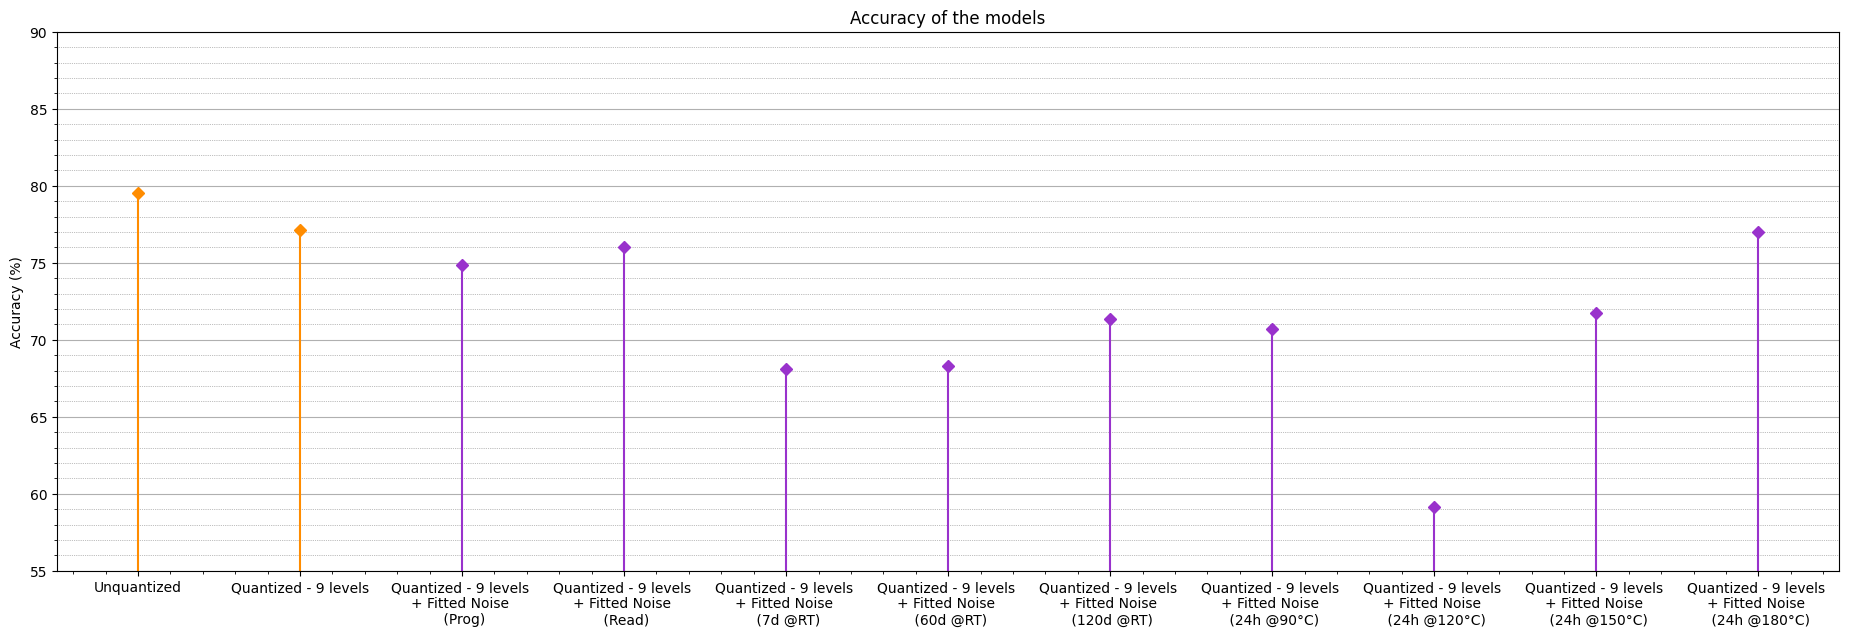

In [ ]:
# Estimate the accuracy of the model with the fitted noise with respect to the other 9 levels model
fitted_models_names = []
fitted_models_accuracy = torch.zeros((len(t_inferences), n_reps, len(types)))
for i in range(len(types)):
    CHOSEN_NOISE = types[i]
    RPU_CONFIG  = CustomDefinedPreset()
    RPU_CONFIG.noise_model=ExperimentalNoiseModel(file_path = path,
                                                    type = CHOSEN_NOISE,
                                                    g_converter=SinglePairConductanceConverter(g_max=40.)),

    original_model = resnet9s().to(device)
    original_model.load_state_dict(state_dict["model_state_dict"], strict=True)

    RPU_CONFIG.quantization = WeightQuantizerParameter(
        resolution=0.2 if SELECTED_LEVEL == 9 else 0.12,
        levels = SELECTED_LEVEL,
    )
    model_fitted = convert_to_analog(original_model, RPU_CONFIG)
    model_fitted.eval()
    model_fitted.program_analog_weights()

    calibrate_input_ranges(
    model=model_fitted,
    calibration_type=InputRangeCalibrationType.CACHE_QUANTILE,
    dataloader=Sampler(test_loader, device),
    )

    fitted_models_names.append(f"Quantized - {SELECTED_LEVEL} levels \n+ Fitted Noise \n ({CHOSEN_NOISE})")
    for t_id, t in enumerate(t_inferences):
        for j in range(n_reps):
            fitted_models_accuracy[t_id, j, i] = evaluate_model(model_fitted, test_loader, device)

fitted_models_accuracy = fitted_models_accuracy.mean(dim=1)
fitted_models_accuracy = fitted_models_accuracy[0]
# At this stage, fitted_models_accuracy contains the mean accuracy of the fitted models for the time t=0
fig, ax = plt.subplots(figsize=(23,7))
models = ["Unquantized",f"Quantized - {SELECTED_LEVEL} levels"] + fitted_models_names
if SELECTED_LEVEL == 9:
    accuracies = [inference_accuracy_values[t_id, :, 0].mean(),inference_accuracy_values[t_id, :, 1].mean()]
else:
    accuracies = [inference_accuracy_values[t_id, :, 0].mean(),inference_accuracy_values[t_id, :, 2].mean()]
accuracies = accuracies + fitted_models_accuracy.tolist()
ax.stem(models[:2], accuracies[:2], linefmt ='darkorange', markerfmt ='D', basefmt=' ')
ax.stem(models[2:], accuracies[2:], linefmt ='darkorchid', markerfmt ='D', basefmt=' ')
ax.set_title("Accuracy of the models")
ax.set_ylabel("Accuracy (%)")
ax.set_xlim([-0.5, len(models)- 0.5])
ax.minorticks_on()
ax.yaxis.grid(True)
ax.yaxis.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax.set_ylim([55, 90])
# Save the plot to file
plt.savefig(f"resnet/plots/accuracy_lenet_FittedNoise_{SELECTED_LEVEL}.png")
plt.show()

### Testing of the quantization function
---

In [ ]:
from src.quantization_testing import test_quantization
# test_quantization()

In [1]:
%matplotlib inline
import os
import torch
from torch import nn, Tensor, device, no_grad, manual_seed
from torch import nn
from torchvision.datasets.utils import download_url
import torch.nn.functional as F
from torchmetrics.functional import accuracy
import torchvision
from torchvision import datasets, transforms
from torch.nn.functional import mse_loss

# Import functions defined in a specific path
import sys
sys.path.append('../src/')


from aihwkit.simulator.configs import ConstantStepDevice, SingleRPUConfig, FloatingPointDevice, FloatingPointRPUConfig
from aihwkit.optim import AnalogSGD
from aihwkit.inference.noise.base import BaseNoiseModel
from aihwkit.inference.noise.pcm import PCMLikeNoiseModel
from aihwkit.inference.compensation.drift import GlobalDriftCompensation
from aihwkit.inference.compensation.base import BaseDriftCompensation
from aihwkit.simulator.configs import InferenceRPUConfig
from aihwkit.simulator.presets.utils import PresetIOParameters
from aihwkit.simulator.parameters import (
    MappingParameter,
    IOParameters,
    PrePostProcessingParameter,
    InputRangeParameter,
    WeightClipParameter,
    WeightRemapParameter,
    WeightModifierParameter,
    WeightQuantizerParameter,
)
from aihwkit.simulator.parameters.enums import (
    WeightClipType,
    BoundManagementType,
    NoiseManagementType,
    WeightNoiseType,
    WeightRemapType,
    WeightModifierType,
)
from aihwkit.nn import AnalogLinearMapped, AnalogConv2d, AnalogSequential, AnalogLinear
# from aihwkit.utils.visualization import plot_device_compact
# from aihwkit.utils.analog_info import analog_summary
# from aihwkit.utils.fitting import fit_measurements
from aihwkit.nn.conversion import convert_to_analog
from aihwkit.utils.analog_info import analog_summary
from aihwkit.inference.calibration import (
    calibrate_input_ranges,
    InputRangeCalibrationType,
)
#from aihwkit.simulator.rpu_base import cuda

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dataclasses import dataclass, field
from typing import Optional

import src.plotting as pl
from src.noise import ExperimentalNoiseModel
from aihwkit.inference.converter.conductance import SinglePairConductanceConverter

device = torch.device("cpu")


from src.utilities import import_mat_file

SELECTED_LEVEL = 9

MAP = {
    9 : "matlab/3bit.mat",
    17 : "matlab/4bit.mat",
}

G_RANGE = [-40, 40]
CONDUCTANCES = {
    9 : [G_RANGE[0] + i * (G_RANGE[1] - G_RANGE[0]) / 8 for i in range(9)],
    17 : [G_RANGE[0] + i * (G_RANGE[1] - G_RANGE[0]) / 16 for i in range(17)]
}

# Extract the data from the .mat file
path = f"./data/{MAP[SELECTED_LEVEL]}"
variables = import_mat_file(path)

types = variables['str']
types = [types[0][t][0] for t in range(types.shape[1])]
ww_mdn = variables['ww_mdn'] * 1e6
ww_std = variables['ww_std'] * 1e6
ww_mdn = pd.DataFrame(ww_mdn, columns=types)
ww_std = pd.DataFrame(ww_std, columns=types)

CHOSEN_NOISE = types[0]

ExperimentalNoiseModel(file_path = path,
                        type = CHOSEN_NOISE,
                        g_converter=SinglePairConductanceConverter(g_max=40.)),

from src.utilities import interpolate

data = interpolate(levels = 5, file_path = path)
types_new = data['str']

types_new = [types_new[0][t][0] for t in range(types_new.shape[1]) if types_new[0][t][0]!= 'Read']
print(types_new)
ww_mdn_new = data['ww_mdn']
ww_std_new = data['ww_std']
ww_mdn_new = torch.tensor(ww_mdn_new[:,types_new.index(CHOSEN_NOISE)]) * 1e6 # handle conversion from muS
ww_std_new = torch.tensor(ww_std_new[:,types_new.index(CHOSEN_NOISE)]) * 1e6 # handle conversion from muS
print(ww_mdn_new)

tensor([-39.5502, -29.9887, -19.5138,  -9.5616,   0.1587,   9.5616,  19.5138,
         29.9887,  39.5502], dtype=torch.float64)
['Prog', '7d @RT', '60d @RT', '120d @RT', '24h @90°C', '24h @120°C', '24h @150°C', '24h @180°C']
tensor([-39.5502,   0.1587,  39.5502], dtype=torch.float64)
